In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Projects/2023-HJ-Prox/src/')

from hj_prox import *
from functions import *
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
device = 'cuda:0'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Approximate Proximals and Moreau Envelopes

The Proximal of $f$ is given by 
\begin{equation}
  \text{prox}_{tf}(x) \triangleq \text{argmin}_{z\in\mathbb{R}^n} f(z) + \dfrac{1}{2t}\|z-x\|^2,
\end{equation}
and the Moreau envelope of $f$ is given by
\begin{equation}
  u(x,t) \triangleq \inf_{z\in \mathbb{R}^n} f(z) + \dfrac{1}{2t}\|z-x\|^2
\end{equation}

We leverage the fact that the solution to the Moreau envelope above satisfies the Hamilton-Jacobi Equation
\begin{equation}
  \begin{split}
    u_t^\delta  + \frac{1}{2}\|Du^\delta  \|^2 \ = \frac{\delta}{2} \Delta u^\delta \qquad &\text{ in }  \mathbb{R}^n\times (0,T]
    \\
    u = f \qquad &\text{ in } \mathbb{R}^n\times \{t = 0\}
  \end{split}
\end{equation}
when $\delta = 0$. 

By adding a viscous term ($\delta > 0$), we are able to approximate the solution to the HJ equation using the Cole-Hopf formula to obtain
\begin{equation}
  u^\delta(x,t) = - \delta \ln\Big(\Phi_t * \exp(-f/\delta)\Big)(x) = - \delta \ln \int_{\mathbb{R}^n} \Phi(x-y,t)  \exp\left(\frac{-f(y)}{\delta}\right) dy 
\end{equation}
where 
\begin{equation}
  \Phi(x,t) = \frac{1}{{(4\pi \delta t)}^{n/2}} \exp{\frac{-\|x\|^2}{4\delta t}}. 
\end{equation}
This allows us to write the Moreau Envelope (and the proximal) explicitly as an expectation. In particular, we obtain
\begin{equation}
  \text{prox}_{tf}(x) = \dfrac{\mathbb{E}_{y \sim  \mathcal{N}_{x, \delta t I}}  \left[y \exp\left(-\delta^{-1}f(y)\right) \right]}{\mathbb{E}_{y \sim  \mathcal{N}_{x, \delta t I}}  \left[\exp\left(-\delta^{-1}f(y)\right) \right]} 
\end{equation}
and 
\begin{equation}
  u(x,t) \approx - \delta \ln \mathbb{E}_{y \sim  \mathcal{N}_{x, \delta t I}}  \left[y \exp\left(-\delta^{-1}f(y)\right) \right]
\end{equation}


In [2]:
# plotting parameters
title_fontsize = 22
fontsize       = 20
fig1 = plt.figure()
my_blue = '#1f77b4'
my_orange = '#F97306'

<Figure size 640x480 with 0 Axes>

# Approximate Prox (Shrink) and Moreau Envelope for L1 Norm

#### Clean L1 Norm Proximal/Moreau Computation

<ipython-input-3-31371be98f0c>:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


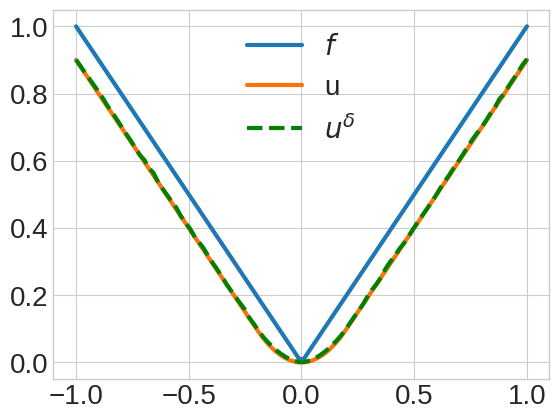

In [3]:
f = l1_norm
analytic_prox = l1_norm_prox

# create a grid of x's for plotting
x = torch.linspace(-1,1,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)
errs = torch.zeros(x.shape, device=device)

t = 2e-1
delta = 1e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope
  envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2

  errs[i] = f(temp) + (temp - x[i])/t


# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'l1_norm_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

In [4]:
#Generate Files for Howard
filename = 'fig2a1_u.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(envelope_true):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

filename = 'fig2a1_udelta.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(envelope_HJ):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

<ipython-input-5-c80673add8e2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


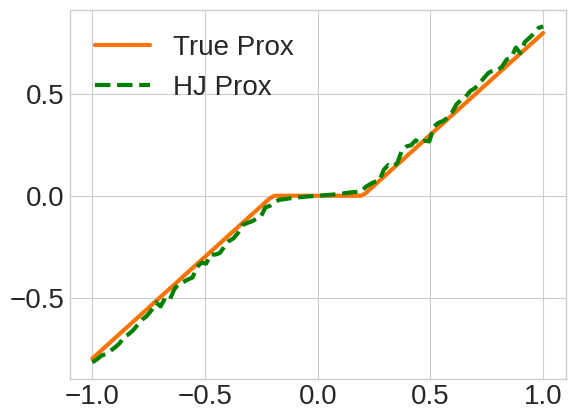

In [5]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.plot(x.cpu(), prox_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), prox_HJ.cpu(), '--', linewidth=3, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['True Prox', 'HJ Prox'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'l1_norm_prox_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

#### Noisy L1 Norm Proximal/Moreau Computation

<ipython-input-6-14052be998c3>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


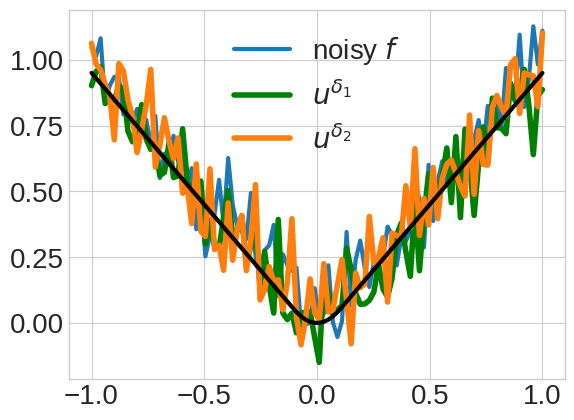

In [6]:
f = l1_norm_noisy
analytic_prox = l1_norm_prox

# create a grid of x's for plotting
x = torch.linspace(-1,1,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
y_vals = f(x)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_HJ2 = torch.zeros(x.shape, device=device)

t = 0.1
delta = 5e-2
delta2 = 1e-2
alpha = 1.0
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta2, alpha=alpha, device=device)
  prox_HJ2[i] = temp
  envelope_HJ2[i] = temp_envelope

# ------------------------ PLOT without noiseless y ------------------------
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)
ax.plot(x.cpu(), envelope_l1_norm(x, t=t).cpu(), 'k', linewidth=3) ###### for save_str = 'eye_candy'

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^{\delta_1}$', '$u^{\delta_2}$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

# save_str = 'l1_norm_envelope_noisy.pdf'
save_str = 'eye_candy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# Approximate Prox and Moreau Envelope for Quadratic Function

<ipython-input-7-e9418ee90c3a>:36: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


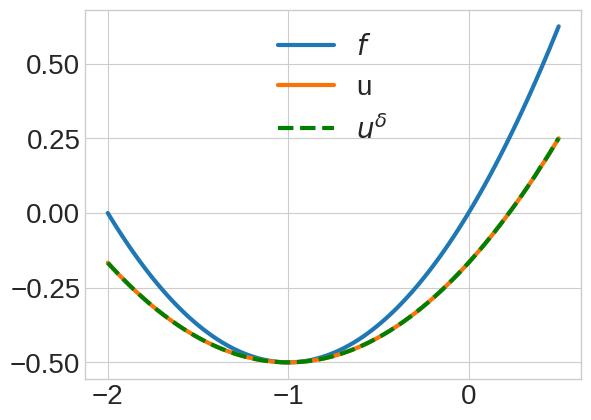

In [7]:
A = torch.ones(1,1, device=device)
A = A.view(1,1)
b = torch.ones(1, device=device)
def f(x):
  return quadratic(x, A, b)

def analytic_prox(x, t=0.5):
  return quadratic_prox(x, A, b, t=t)

f = f

# create a grid of x's for plotting
x = torch.linspace(-2.0,0.5,100, device=device).view(-1,1)
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 5e-1
delta = 5e-2
alpha = 1.0
y_vals = f(x)
errs = torch.zeros(x.shape, device=device)
prox_true = analytic_prox(x, t=t)
prox_HJ = torch.zeros(x.shape, device=device)

n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  errs[i] = f(temp) + (temp - x[i])/t
  envelope_HJ[i] = temp_envelope
  envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'quadratic_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

In [8]:
# Figs for Howard
filename = 'fig2a2_udelta.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(envelope_HJ):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

<ipython-input-9-f213e4ce4ac9>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


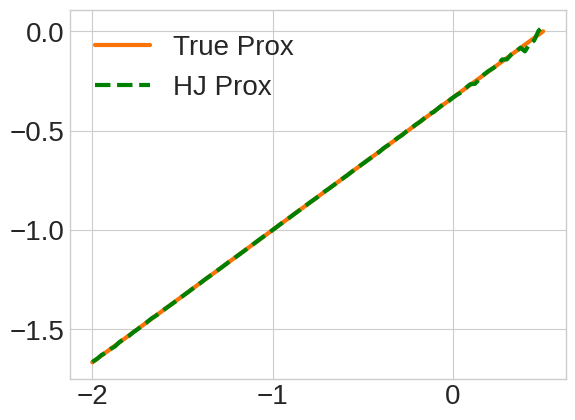

In [9]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.plot(x.cpu(), prox_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), prox_HJ.cpu(), '--', linewidth=3, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['True Prox', 'HJ Prox'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'quadratic_prox_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

In [10]:
# Figs for Howard
filename = 'fig2a2_hjprox.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(prox_HJ):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

### Noisy Quadratic Moreau and Prox

<ipython-input-11-754e1ba4d0d8>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


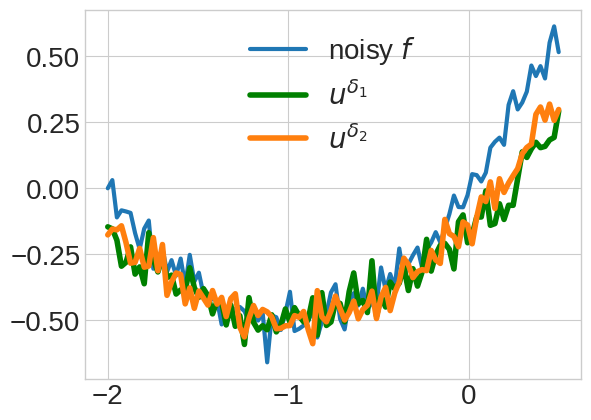

In [11]:
def f(x):
  return quadratic_noisy(x, A, b)

y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 5e-1
delta = 5e-2
delta2 = 1e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta2, alpha=alpha, device=device)
  prox_HJ2[i] = temp
  envelope_HJ2[i] = temp_envelope

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^{\delta_1}$', '$u^{\delta_2}$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'quadratic_envelope_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

In [12]:
# Figs for Howard
filename = 'fig2d2_noisyf.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(y_vals):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

# Figs for Howard
filename = 'fig2d2_udelta1.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(envelope_HJ):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

# Figs for Howard
filename = 'fig2d2_udelta2.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(envelope_HJ2):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

<ipython-input-13-dfba4c3aef84>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


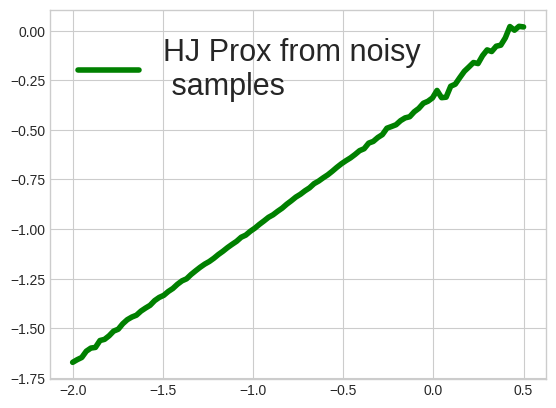

In [13]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

# ax.plot(x.cpu(), prox_true.cpu(), linewidth=4)
ax.plot(x.cpu(), prox_HJ.cpu(), linewidth=4, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['HJ Prox from noisy \n samples'],fontsize=fontsize+2, loc=2)
# ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'quadratic_prox_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# Approximate Prox and Moreau Envelope for Log Barrier

<ipython-input-15-a788420ea3cb>:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


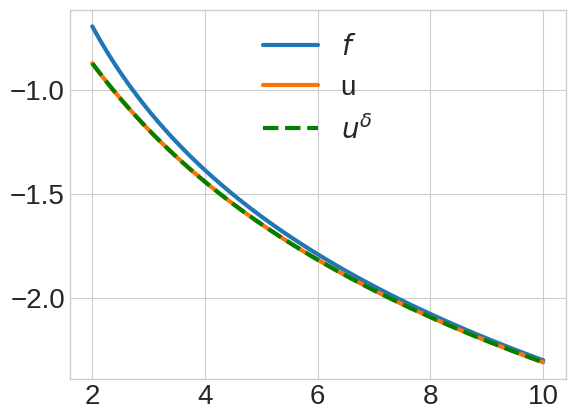

In [15]:
f = log_barrier
analytic_prox = log_barrier_prox

# create a grid of x's for plotting
x = torch.linspace(2,10,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)
errs = torch.zeros(x.shape, device=device)

t = 2.0
delta = 1e-1
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope
  envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2

  errs[i] = f(temp) + (temp - x[i])/t


# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'log_barrier_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

<ipython-input-16-cc2ac5705551>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


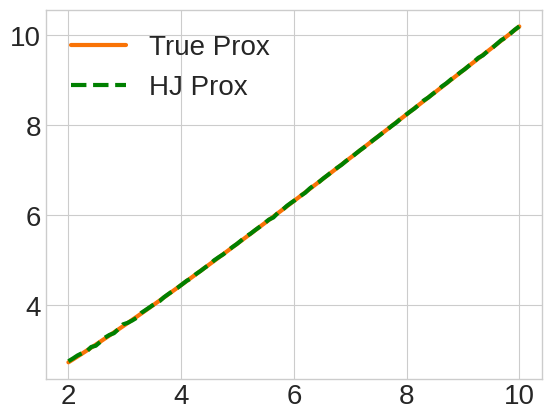

In [16]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.plot(x.cpu(), prox_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), prox_HJ.cpu(), '--', linewidth=3, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['True Prox', 'HJ Prox'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'log_barrier_prox_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

### Noisy Log Barrier

<ipython-input-17-65d0accfa9cf>:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


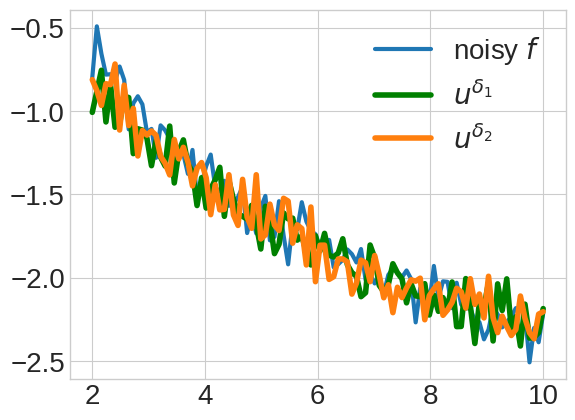

In [17]:
f = log_barrier_noisy
analytic_prox = log_barrier_prox

# create a grid of x's for plotting
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 2.0
delta = 5e-2
delta2 = 1e-2
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta2, alpha=alpha, device=device)
  prox_HJ2[i] = temp
  envelope_HJ2[i] = temp_envelope

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^{\delta_1}$', '$u^{\delta_2}$'],fontsize=fontsize, loc=1)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'log_barrier_envelope_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

In [18]:
# Figs for Howard
filename = 'fig2d3_noisyf.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(y_vals):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

# Figs for Howard
filename = 'fig2d3_udelta1.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(envelope_HJ):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

# Figs for Howard
filename = 'fig2d3_udelta2.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(envelope_HJ2):
    csv_file.write('%0.5e %0.5e\n' % (x[idx], f_val))

# Nonconvex Moreau Envelopes with Analytic Formulas

<ipython-input-19-e38f0bd84404>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


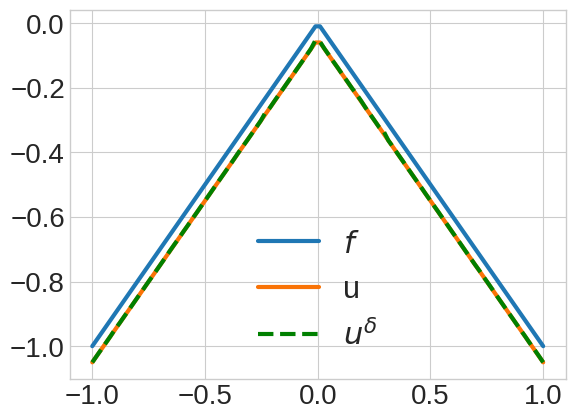

In [19]:
def f(x):
  return -torch.norm(x, p=1, dim=1)

# create a grid of x's for plotting
x = torch.linspace(-1.0,1.0,100, device=device).view(-1,1)
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 1e-1
delta = 1e-2
alpha = 1.0
y_vals = f(x)
errs = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
prox_HJ = torch.zeros(x.shape, device=device)

n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  # print('f(x[i].view(1,1)) = ', f(x[i].view(1,1)))
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  errs[i] = f(temp) + (temp - x[i])/t
  envelope_HJ[i] = temp_envelope
  # envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2
  envelope_true[i] = -torch.norm(x[i].view(1,1), p=1, dim=1) - t/2
  # prox_true[i] = 

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize+2, loc=8)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'nonconvex1_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

<ipython-input-20-7c5ebcd98e9d>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


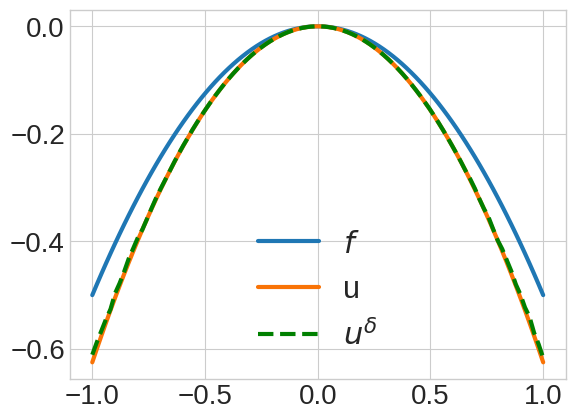

In [20]:
def f(x, a=1):
  return -(a/2)* torch.norm(x, p=2, dim=1)**2

f = f

# create a grid of x's for plotting
x = torch.linspace(-1.0,1.0,100, device=device).view(-1,1)
y_vals = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)

t = 2e-1
delta = 1e-2
alpha = 1.0
a = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
errs = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
prox_HJ = torch.zeros(x.shape, device=device)

n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  # print('f(x[i].view(1,1)) = ', f(x[i].view(1,1)))
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  errs[i] = f(temp) + (temp - x[i])/t
  envelope_HJ[i] = temp_envelope
  # envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2
  envelope_true[i] = -(a/(2*(1-a*t)))* torch.norm(x[i].view(1,1), p=2, dim=1)**2
# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize+2, loc=8)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'nonconvex2_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# Convex Functions with Unknown Proxes

In [21]:
def proximal_objective(z, x):
  # assumes only one sample
  return torch.norm(z)**2 - torch.sum(torch.log(z)) + (1/(2*t)) * torch.norm(z - x)**2

def proximal_objective_gradient(z, x):
  return 2*z - (1/z) + (1/t)*(z-x)

In [22]:
def steepest_descent(x, f, grad_f, max_iters=1000, tol=1e-2, step_size = 1e-1, verbose=True):
  # assumes only one sample
  xk = x
  fk = f(xk)
  grad_fk = grad_f(xk)
  norm_grad0 = torch.norm(grad_fk)

  print('iter = 0', ', fk = ', fk, '|grad_fk| = ', 1)

  for i in range(max_iters):
    xk = xk - step_size*grad_fk

    rel_grad_norm = torch.norm(grad_fk)/norm_grad0
    if verbose:
      print('iter = ', i+1, ', fk = ', ', |grad_fk| = ', rel_grad_norm)

    fk = f(xk)
    grad_fk = grad_f(xk)

    if rel_grad_norm < tol:
      print('SD converged in ', i, ' iterations')
      break

  return xk

def evaluate_proximal(x):
  def func(z):
    return proximal_objective(z,x)
  def grad_func(z):
    return proximal_objective_gradient(z,x)

  prox_val = steepest_descent(x, func, grad_func)

  return prox_val

iter = 0 , fk =  tensor(1., device='cuda:0') |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1., device='cuda:0')
iter =  2 , fk =  , |grad_fk| =  tensor(0.3111, device='cuda:0')
iter =  3 , fk =  , |grad_fk| =  tensor(0.0993, device='cuda:0')
iter =  4 , fk =  , |grad_fk| =  tensor(0.0315, device='cuda:0')
iter =  5 , fk =  , |grad_fk| =  tensor(0.0100, device='cuda:0')
SD converged in  4  iterations
iter = 0 , fk =  tensor(1.0208, device='cuda:0') |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1., device='cuda:0')
iter =  2 , fk =  , |grad_fk| =  tensor(0.3072, device='cuda:0')
iter =  3 , fk =  , |grad_fk| =  tensor(0.0969, device='cuda:0')
iter =  4 , fk =  , |grad_fk| =  tensor(0.0303, device='cuda:0')
iter =  5 , fk =  , |grad_fk| =  tensor(0.0095, device='cuda:0')
SD converged in  4  iterations
iter = 0 , fk =  tensor(1.0428, device='cuda:0') |grad_fk| =  1
iter =  1 , fk =  , |grad_fk| =  tensor(1., device='cuda:0')
iter =  2 , fk =  , |grad_fk| =  tensor(0.3035,

<ipython-input-23-c7672a6b1f1e>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


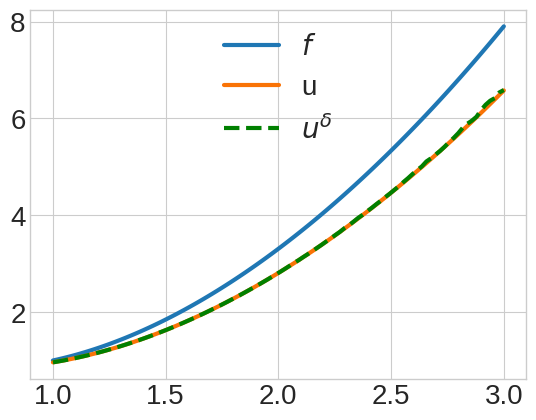

In [23]:
def f(x):
  return torch.norm(x, dim=1)**2 - torch.sum(torch.log(x), dim=1)
# create a grid of x's for plotting

x = torch.linspace(1,3,100).view(-1,1).to(device)
y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)
errs = torch.zeros(x.shape, device=device)

t = 0.1
delta = 1e-1
alpha = 1.0
y_vals = f(x)

prox_HJ = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e5)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope
  prox_true[i] = evaluate_proximal(x[i])
  envelope_true[i] = f(prox_true[i].view(1,1)) + (1/(2*t))*torch.norm(prox_true[i] - x[i], p=2)**2

  errs[i] = f(temp) + (temp - x[i])/t


# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), envelope_HJ.cpu(), '--g', linewidth=3)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['$f$', 'u', '$u^\delta$'],fontsize=fontsize, loc=9)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'non_analytic_convex_envelope.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

<ipython-input-25-749aff71ffe3>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


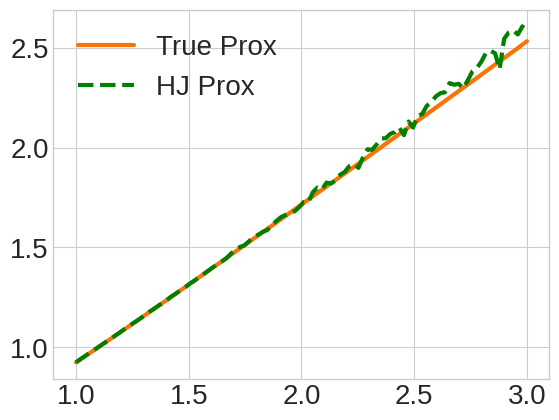

In [25]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

ax.plot(x.cpu(), prox_true.cpu(), linewidth=3, color=my_orange)
ax.plot(x.cpu(), prox_HJ.cpu(), '--', linewidth=3, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['True Prox', 'HJ Prox'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'non_analytic_convex_prox_comparison.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

<ipython-input-26-26e0534142f9>:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


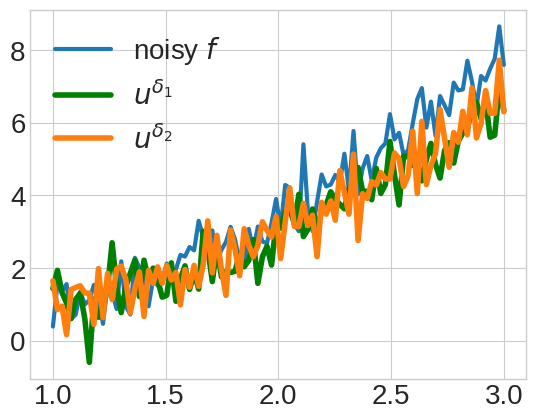

In [26]:
def f_noisy(x):
  return torch.norm(x, dim=1)**2 - torch.sum(torch.log(x), dim=1) + 5e-1*torch.randn(x.shape[0], device=x.device)

f = f_noisy

y_vals = torch.zeros(x.shape, device=device)
prox_true = torch.zeros(x.shape, device=device)
envelope_HJ = torch.zeros(x.shape, device=device)
envelope_true = torch.zeros(x.shape, device=device)
errs = torch.zeros(x.shape, device=device)

t = 1e-1
delta = 5e-1
delta2 = 1e-1
alpha = 1.0
# y_vals = l1_norm(x) + 0.1*torch.randn(x.shape[0], device=device)
y_vals = f(x)
prox_true = analytic_prox(x, t=t)

prox_HJ = torch.zeros(prox_true.shape, device=device)
prox_HJ2 = torch.zeros(prox_true.shape, device=device)
n_integral_samples = int(1e4)
for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta, alpha=alpha, device=device)
  prox_HJ[i] = temp
  envelope_HJ[i] = temp_envelope

for i in range(x.shape[0]):
  temp, ls_iters, temp_envelope = compute_prox(x[i].view(1,1), t, f, int_samples = n_integral_samples, delta = delta2, alpha=alpha, device=device)
  prox_HJ2[i] = temp
  envelope_HJ2[i] = temp_envelope

# PLOT
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.plot(x.cpu(), y_vals.cpu(), linewidth=3);
ax.plot(x.cpu(), envelope_HJ.cpu(), linewidth=4, color='g')
ax.plot(x.cpu(), envelope_HJ2.cpu(), linewidth=4)

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['noisy $f$', '$u^{\delta_1}$', '$u^{\delta_2}$'],fontsize=fontsize, loc=2)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'non_analytic_convex_envelope_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

<ipython-input-27-29a46d037b0c>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


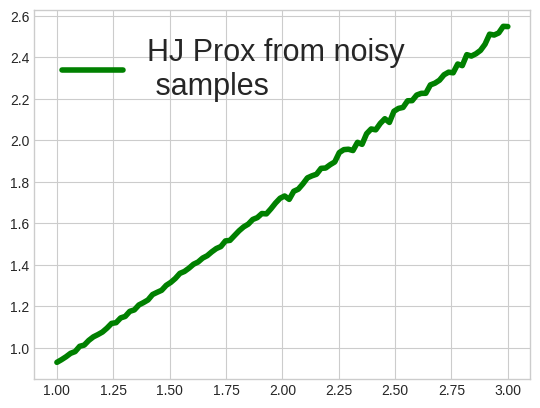

In [27]:
fig1 = plt.figure()
plt.style.use('seaborn-whitegrid')
ax = plt.axes()

# ax.plot(x.cpu(), prox_true.cpu(), linewidth=4)
ax.plot(x.cpu(), prox_HJ.cpu(), linewidth=4, color='g')

# ax.set_xlabel("x-axis", fontsize=title_fontsize)
ax.legend(['HJ Prox from noisy \n samples'],fontsize=fontsize+2, loc=2)
# ax.tick_params(labelsize=fontsize, which='both', direction='in')
save_str = 'non_analytic_convex_prox_noisy.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

# High Dimensional Shrink Experiments



In [29]:
f = l1_norm
analytic_prox = l1_norm_prox

dim_array = [10, 25, 50, 75, 100]
n_samples = int(1000)
n_integral_samples_array = [int(1e1), int(1e3), int(1e4), int(1e5)]
rel_errs_array = torch.zeros(len(dim_array), len(n_integral_samples_array))
torch.manual_seed(2)
delta = 1e-1
t = 1e-2

for k in range(len(dim_array)):
  print('\n DIMENSION = ', dim_array[k])
  for i in range(len(n_integral_samples_array)):
    x = torch.randn(n_samples, dim_array[k], device=device)
    prox_true = analytic_prox(x, t=t) 
    for j in range(n_samples): # need to loop over samples since HJ prox can only handle one sample at a time
      # print('x[j,:].unsqueeze(1).shape = ', x[j,:].unsqueeze(1).shape)
      prox_HJ, ls_iters, temp_envelope = compute_prox(x[j,:].unsqueeze(1), t, f, int_samples = n_integral_samples_array[i], delta = delta, alpha=alpha, device=device)
      # NOTE: need to permute prox_HJ back to n_samples x dim
      # print('prox_true[j,:].shape = ', prox_true[j,:].shape)
      # print('prox_HJ.squeeze(1)shape = ', prox_HJ.squeeze(1).shape)
      rel_errs_array[k, i] = rel_errs_array[k, i] + torch.norm(prox_true[j,:].cpu() - prox_HJ.squeeze(1).cpu())/torch.norm(prox_true[j,:].cpu()) 

    rel_errs_array[k, i] = rel_errs_array[k, i]/n_samples
    print('dim = ', dim_array[k], ', n_integral_samples = ', n_integral_samples_array[i], ', rel err = ', rel_errs_array[k, i], ', ls_iters = ', ls_iters)


 DIMENSION =  10
dim =  10 , n_integral_samples =  10 , rel err =  tensor(0.0153) , ls_iters =  1
dim =  10 , n_integral_samples =  1000 , rel err =  tensor(0.0021) , ls_iters =  1
dim =  10 , n_integral_samples =  10000 , rel err =  tensor(0.0010) , ls_iters =  1
dim =  10 , n_integral_samples =  100000 , rel err =  tensor(0.0007) , ls_iters =  1

 DIMENSION =  25
dim =  25 , n_integral_samples =  10 , rel err =  tensor(0.0181) , ls_iters =  1
dim =  25 , n_integral_samples =  1000 , rel err =  tensor(0.0034) , ls_iters =  1
dim =  25 , n_integral_samples =  10000 , rel err =  tensor(0.0014) , ls_iters =  1
dim =  25 , n_integral_samples =  100000 , rel err =  tensor(0.0009) , ls_iters =  1

 DIMENSION =  50
dim =  50 , n_integral_samples =  10 , rel err =  tensor(0.0209) , ls_iters =  1
dim =  50 , n_integral_samples =  1000 , rel err =  tensor(0.0064) , ls_iters =  1
dim =  50 , n_integral_samples =  10000 , rel err =  tensor(0.0029) , ls_iters =  1
dim =  50 , n_integral_samples =

<ipython-input-30-e40ab8e14fd5>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


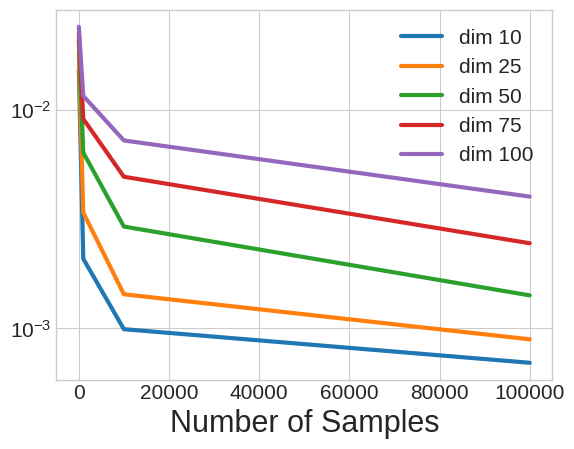

In [30]:
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

title_fontsize = 22
fontsize       = 15
my_blue = '#1f77b4'

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
for i in range(len(dim_array)):
  ax.semilogy(n_integral_samples_array, rel_errs_array[i,:], linewidth=3);

ax.set_xlabel("Number of Samples", fontsize=title_fontsize)
ax.legend(['dim 10', 'dim 25', 'dim 50', 'dim 75', 'dim 100'],fontsize=fontsize, loc=1)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'shrink_higher_dim_err_vs_samples.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

### High Dimensional Quadratic Experiments

In [31]:
dim_array = [10, 25, 50, 75, 100]
n_samples = 1000
n_integral_samples_array = [int(1e0), int(1e2), int(1e3), int(1e4)]
rel_errs_array = torch.zeros(len(dim_array), len(n_integral_samples_array))
torch.manual_seed(2)
delta = 1e-1
t = 1e-2


for k in range(len(dim_array)):
  print('\n DIMENSION = ', dim_array[k])
  for i in range(len(n_integral_samples_array)):
    for j in range(n_samples): # need to loop over samples since HJ prox can only handle one sample at a time
      A = torch.eye(dim_array[k], device=device)
      # A = torch.randn(dim_array[k], dim_array[k], device=device)
      # A = A + A.t() + torch.eye(dim_array[k], device=device)
      b = torch.ones(A.shape[0], device=device)
      def f(x):
        return quadratic(x, A, b)

      def analytic_prox(x, t=0.5):
        return quadratic_prox(x, A, b, t=t)
      f = f
      x = torch.randn(dim_array[k],1, device=device)
      prox_true = analytic_prox(x.permute(1,0), t=t)
      prox_HJ, ls_iters, envelopes = compute_prox(x, t, f, int_samples = n_integral_samples_array[i], delta = delta, alpha=alpha, device=device)
      # NOTE: need to permute prox_HJ back to n_samples x dim
      rel_errs_array[k, i] = rel_errs_array[k, i] + torch.norm(prox_true.cpu() - prox_HJ.permute(1,0).cpu())/torch.norm(prox_true.cpu())  

    rel_errs_array[k, i] = rel_errs_array[k, i]/n_samples
    print('dim = ', dim_array[k], ', n_integral_samples = ', n_integral_samples_array[i], ', rel err = ', rel_errs_array[k, i], ', ls_iters = ', ls_iters)


 DIMENSION =  10
dim =  10 , n_integral_samples =  1 , rel err =  tensor(0.0367) , ls_iters =  1
dim =  10 , n_integral_samples =  100 , rel err =  tensor(0.0076) , ls_iters =  1
dim =  10 , n_integral_samples =  1000 , rel err =  tensor(0.0029) , ls_iters =  1
dim =  10 , n_integral_samples =  10000 , rel err =  tensor(0.0010) , ls_iters =  1

 DIMENSION =  25
dim =  25 , n_integral_samples =  1 , rel err =  tensor(0.0358) , ls_iters =  1
dim =  25 , n_integral_samples =  100 , rel err =  tensor(0.0125) , ls_iters =  1
dim =  25 , n_integral_samples =  1000 , rel err =  tensor(0.0063) , ls_iters =  1
dim =  25 , n_integral_samples =  10000 , rel err =  tensor(0.0028) , ls_iters =  1

 DIMENSION =  50
dim =  50 , n_integral_samples =  1 , rel err =  tensor(0.0352) , ls_iters =  1
dim =  50 , n_integral_samples =  100 , rel err =  tensor(0.0174) , ls_iters =  1
dim =  50 , n_integral_samples =  1000 , rel err =  tensor(0.0119) , ls_iters =  1
dim =  50 , n_integral_samples =  10000 , r

<ipython-input-32-ff10d27841a8>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


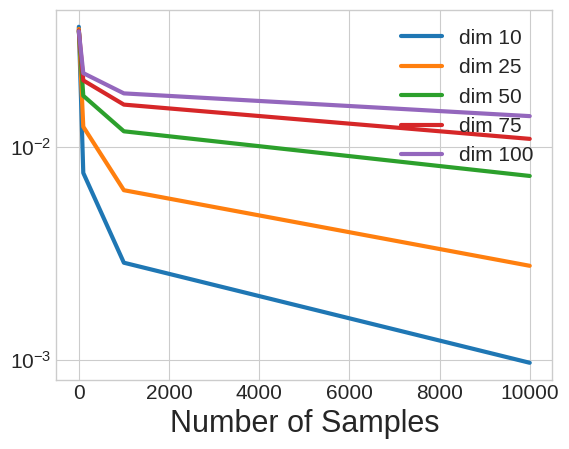

In [32]:
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

title_fontsize = 22
fontsize       = 15
my_blue = '#1f77b4'

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
for i in range(len(dim_array)):
  ax.semilogy(n_integral_samples_array, rel_errs_array[i,:], linewidth=3);

ax.set_xlabel("Number of Samples", fontsize=title_fontsize)
ax.legend(['dim 10', 'dim 25', 'dim 50', 'dim 75', 'dim 100'],fontsize=fontsize, loc=1)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'quadratic_higher_dim_err_vs_samples.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

### High Dimensional Log Barrier Experiments

In [33]:
f = log_barrier
analytic_prox = log_barrier_prox

dim_array = [10, 25, 50, 75, 100]
n_samples = 1000
n_integral_samples_array = [int(1e0), int(1e2), int(1e3), int(1e4)]
rel_errs_array = torch.zeros(len(dim_array), len(n_integral_samples_array))
torch.manual_seed(2)
delta = 2e-1
t = 1e-2


for k in range(len(dim_array)):
  print('\n DIMENSION = ', dim_array[k])
  for i in range(len(n_integral_samples_array)):
    for j in range(n_samples): # need to loop over samples since HJ prox can only handle one sample at a time
      x = torch.rand(dim_array[k],1, device=device) + 2
      prox_true = analytic_prox(x.permute(1,0), t=t)
      prox_HJ, ls_iters, envelopes = compute_prox(x, t, f, int_samples = n_integral_samples_array[i], delta = delta, alpha=alpha, device=device)
      # NOTE: need to permute prox_HJ back to n_samples x dim
      rel_errs_array[k, i] = rel_errs_array[k, i] + torch.norm(prox_true.cpu() - prox_HJ.permute(1,0).cpu())/torch.norm(prox_true.cpu())  

    rel_errs_array[k, i] = rel_errs_array[k, i]/n_samples
    print('dim = ', dim_array[k], ', n_integral_samples = ', n_integral_samples_array[i], ', rel err = ', rel_errs_array[k, i], ', ls_iters = ', ls_iters)


 DIMENSION =  10
dim =  10 , n_integral_samples =  1 , rel err =  tensor(0.0173) , ls_iters =  1
dim =  10 , n_integral_samples =  100 , rel err =  tensor(0.0018) , ls_iters =  1
dim =  10 , n_integral_samples =  1000 , rel err =  tensor(0.0006) , ls_iters =  1
dim =  10 , n_integral_samples =  10000 , rel err =  tensor(0.0002) , ls_iters =  1

 DIMENSION =  25
dim =  25 , n_integral_samples =  1 , rel err =  tensor(0.0176) , ls_iters =  1
dim =  25 , n_integral_samples =  100 , rel err =  tensor(0.0019) , ls_iters =  1
dim =  25 , n_integral_samples =  1000 , rel err =  tensor(0.0006) , ls_iters =  1
dim =  25 , n_integral_samples =  10000 , rel err =  tensor(0.0002) , ls_iters =  1

 DIMENSION =  50
dim =  50 , n_integral_samples =  1 , rel err =  tensor(0.0177) , ls_iters =  1
dim =  50 , n_integral_samples =  100 , rel err =  tensor(0.0022) , ls_iters =  1
dim =  50 , n_integral_samples =  1000 , rel err =  tensor(0.0007) , ls_iters =  1
dim =  50 , n_integral_samples =  10000 , r

<ipython-input-34-21601891ee5b>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


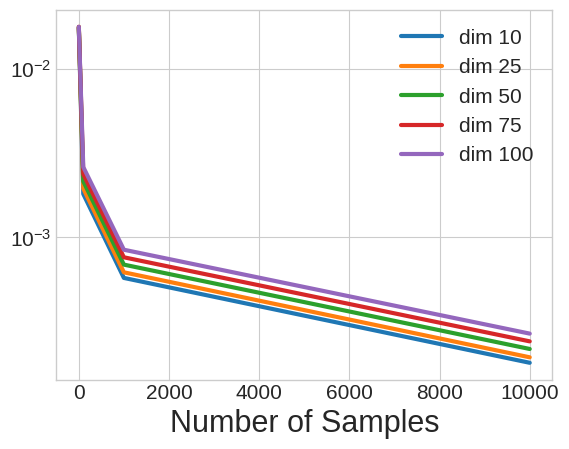

In [34]:
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

title_fontsize = 22
fontsize       = 15
my_blue = '#1f77b4'

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
for i in range(len(dim_array)):
  ax.semilogy(n_integral_samples_array, rel_errs_array[i,:], linewidth=3);

ax.set_xlabel("Number of Samples", fontsize=title_fontsize)
ax.legend(['dim 10', 'dim 25', 'dim 50', 'dim 75', 'dim 100'],fontsize=fontsize, loc=1)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'log_barrier_higher_dim_err_vs_samples.pdf'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)